In [53]:
#correlation matrix
library(FactoMineR)
library(RSQLite)
drv = SQLite()
conn = dbConnect(drv, dbname = './database')
# #getting max exp for genes where dev expression is highest, then bind to results for not dev expression
result <- dbGetQuery(conn, 'SELECT 
                              gene_features.id, 
                              gene_features.gLength,
                              gene_features.cds_len,  
                              gene_features.unique_domains, 
                              gene_features.domains, 
                              gene_features.motif_number_1k, 
                              gene_features.gc3, 
                              gene_features.max_exp,
                              gene_features.med_exp,
                              gene_features.specificity,
                              gene_features.trans_count,
                              gene_features.intron_count,
                              gene_features.intron_length,
                              gene_features.avg_intron,
                              dn_ds,
                              dup_type
                            FROM 
                              gene_features
                            INNER JOIN 
                              macaque_paralogs 
                            ON 
                              gene_features.id == macaque_paralogs.id
                            WHERE 
                              NOT macaque_paralogs.dn_ds IS NULL
                              AND macaque_paralogs.dn_ds < 10
                              AND (dup_type == "WGD" OR dup_type == "SSD")')[,-1]

result <- na.omit(result)
result$gLength <- log10(result$gLength)
result$max_exp <- log10(result$max_exp)
result$gc3 <- 100 * result$gc3
library("Hmisc")
res2 <- rcorr(as.matrix(result[,-15]), type = 'pearson')
corr <- res2$r
pval <- res2$P

write.csv(corr, file= 'corr.csv')
write.csv(pval, file= 'corr_pval.csv')

res3 <- rcorr(as.matrix(result[,-15]), type = 'spearman')
corr2 <- res3$r
pval2 <- res3$P

write.csv(corr2, file= 'corr_spearman.csv')
write.csv(pval2, file= 'corr_pval_spearman.csv')

# for (i in 1:length(names(result)))
# {
#     for (j in 1:length(names(result)))
#     {
#         cor = cor.test(result[,i], result[,j], method = 'pearson')
#         print(names(result[i]))
#         print(names(result[j]))
#         print(cor$p.value)
#         print(cor$estimate['cor'])
#     }
# }

In [54]:
corr_results <- result[,c(1:4,8,9,11:13)]
#PCA
png('tester.png', width = 1000, height = 500)
pca_res <- PCA(corr_results, graph = F)
plot(pca_res)
# pca_res$eig
# pca_res$var$cor
dev.off()

pdf 
  2

In [55]:
PCA1 <- pca_res$ind$coord[,1]

PCA2 <- pca_res$ind$coord[,2]

PCA3 <- pca_res$ind$coord[,3]

In [56]:
pca_res$eig
pca_res$var$cor
pca_res$var$contrib
sum(pca_res$var$contrib)

,eigenvalue,percentage of variance,cumulative percentage of variance
comp 1,3.3916356,37.684840,37.68484
comp 2,1.7126392,19.029324,56.71416
comp 3,1.1403051,12.670057,69.38422
comp 4,0.8423408,9.359342,78.74356
comp 5,0.7300701,8.111890,86.85545
comp 6,0.4409285,4.899206,91.75466
comp 7,0.2925747,3.250830,95.00549
comp 8,0.2848858,3.165398,98.17089
comp 9,0.1646202,1.829113,100.00000


,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
gLength,0.77683380,0.39729110,-0.07849481,-0.078700613,-0.16017692
cds_len,0.78287731,-0.31549844,0.05088270,-0.009844906,-0.31618282
unique_domains,0.62785165,-0.42911308,0.05210603,0.044617626,0.48222467
domains,0.64147728,-0.49578468,0.09211037,0.064152043,0.35300266
med_exp,-0.06352906,-0.12668057,-0.75604989,0.637383965,-0.03149820
specificity,-0.20580925,-0.04697256,0.73872311,0.619121782,-0.12716471
intron_count,0.81634759,-0.25952283,-0.01138565,0.013783279,-0.39913749
intron_length,0.69622761,0.56471420,0.03928018,0.137857923,0.04548343
avg_intron,0.41476196,0.78791533,0.03687068,0.145529922,0.26219824


,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
gLength,17.7929126,9.2161983,0.54033216,0.73530651,3.5142716
cds_len,18.0708355,5.8120396,0.22704878,0.01150629,13.6934211
unique_domains,11.6226429,10.7517124,0.23809753,0.23633339,31.8518208
domains,12.1325858,14.3522614,0.74403949,0.48857716,17.0683438
med_exp,0.1189969,0.9370314,50.12793720,48.22968728,0.1358960
specificity,1.2488796,0.1288317,47.85665003,45.50554772,2.2149741
intron_count,19.6490269,3.9326498,0.01136827,0.02255367,21.8212924
intron_length,14.2920098,18.6205089,0.13530873,2.25618986,0.2833621
avg_intron,5.0721099,36.2487665,0.11921780,2.51429813,9.4166181


[1] 500

In [24]:
d <- as.data.frame(pca_res$var$contrib)
sum(d$Dim.1)

[1] 100

In [ ]:
non_corr <- result[,c(5:7,10,14,15)]
non_corr

In [ ]:
final_df <- cbind(non_corr, PCA1, PCA2, PCA3)
final_df

In [68]:
for(i in 1:nrow(final_df)) #makes 1 and 0 strings for some stupid reason
{
    if(final_df[i,]['dup_type'] == 'WGD')
    {
        final_df[i,]['dup_type'] <- 1
    }
    if(final_df[i,]['dup_type'] == 'SSD')
    {
        final_df[i,]['dup_type'] <- 0
    }
}

In [73]:
final_df$dup_type <- as.numeric(final_df$dup_type)
model <- glm(dup_type ~ . , data = train, family = binomial)

In [74]:
summary(model)


Call:
glm(formula = dup_type ~ ., family = binomial, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8949  -1.0736   0.6401   0.9725   2.7008  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.7267495  0.1638283  -4.436 9.16e-06 ***
motif_number_1k  0.0172418  0.0028917   5.963 2.48e-09 ***
gc3              0.0200420  0.0019886  10.078  < 2e-16 ***
max_exp          0.0790778  0.0509914   1.551    0.121    
trans_count     -0.0002535  0.0065636  -0.039    0.969    
dn_ds           -1.8086131  0.1407480 -12.850  < 2e-16 ***
PCA1             0.2460461  0.0223274  11.020  < 2e-16 ***
PCA2             0.3624760  0.0319896  11.331  < 2e-16 ***
PCA3            -0.0221078  0.0284627  -0.777    0.437    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8166.7  on 5999  degrees of freedom
Residual deviance: 7232.9  on 59

In [194]:
for(i in 1:length(s$coefficients[,'Pr(>|t|)']))
{
    if(s$coefficients[,'Pr(>|t|)'][i] < 0.05)
    {
        print(row.names(s$coefficients)[i])
    }
}


[1] "(Intercept)"
[1] "exp"


In [114]:
train <- final_df[1:4000,]
test <- final_df[4001:nrow(final_df),]
pred <- predict(model2, test, type='response')
actual <- test$dup_type


In [113]:
model2 <- glm(dup_type ~ (dn_ds + PCA1 + PCA2)^2 -PCA1:dn_ds -PCA1:PCA2, data = train, family = binomial)

summary(model2)


Call:
glm(formula = dup_type ~ (dn_ds + PCA1 + PCA2)^2 - PCA1:dn_ds - 
    PCA1:PCA2, family = binomial, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1938  -1.1623   0.7297   0.9762   2.8771  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.98350    0.05337  18.427  < 2e-16 ***
dn_ds       -2.32897    0.16423 -14.181  < 2e-16 ***
PCA1         0.21107    0.02235   9.445  < 2e-16 ***
PCA2         0.19676    0.05463   3.602 0.000316 ***
dn_ds:PCA2   0.86677    0.20116   4.309 1.64e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5453.6  on 3999  degrees of freedom
Residual deviance: 4939.4  on 3995  degrees of freedom
AIC: 4949.4

Number of Fisher Scoring iterations: 4


In [ ]:
d <- seq(6, 0, -0.01)
g <- seq(0.2, 1, length.out = length(d))
p1 <- seq(-4, 25, length.out = length(d))
p2 <- seq(-18, 17, length.out = length(d))

test_df <- data.frame(d,g,p1,p2)
names(test_df) <- c('dn_ds', 'gc3', 'PCA1', 'PCA2')
test_df[1:200,]

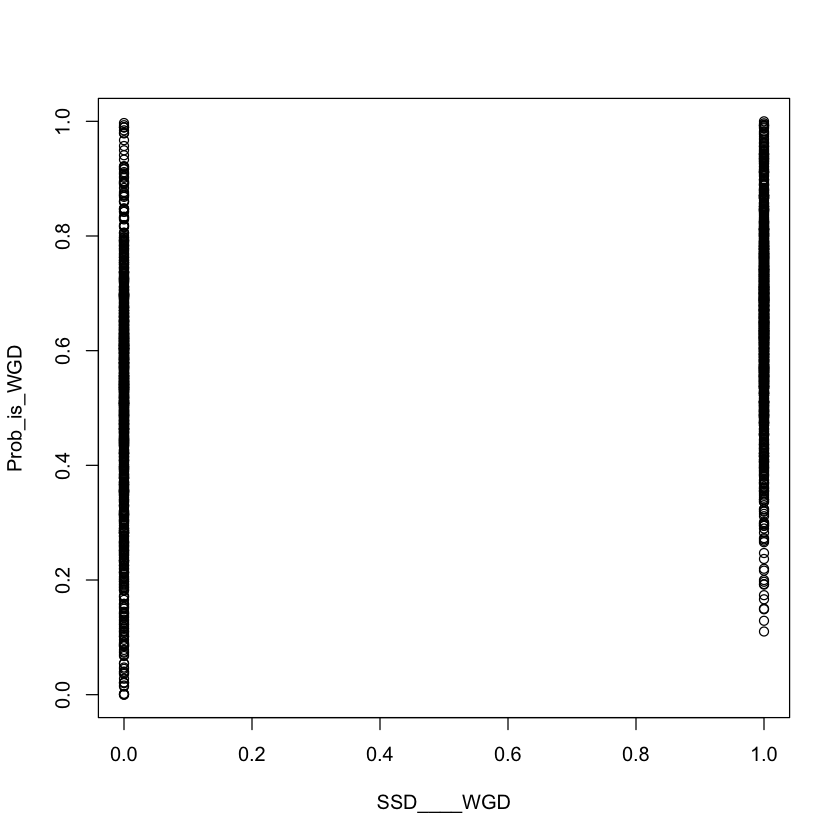

In [115]:
# y1 <- predict(model, test_df, type="response")
# x1 <- seq(1,601)

Prob_is_WGD <- pred
SSD____WGD <- actual
plot(SSD____WGD, Prob_is_WGD)

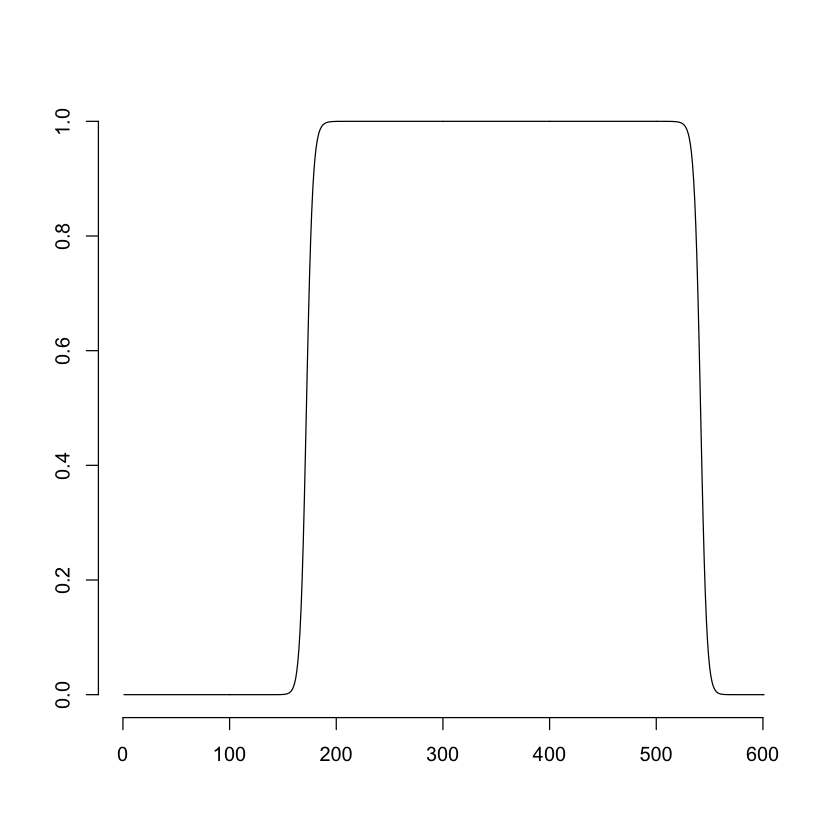

In [16]:
plot.new()

plot.window(xlim=c(1,601), ylim=c(0,1))
axis(1)
axis(2)

lines(x1,y1)
# plot(real_points_x, real_points_y)

In [1]:
library(Hmisc)

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units



In [80]:
length(final_df)

[1] 9

In [81]:
nrow(final_df)

[1] 6889

In [72]:
train <- final_df[1:6000,]
test <- final_df[6001:nrow(final_df),]
